# Real-time Valuation

## Introduction

This notebook demonstrates how to configure LUSID to perform a [*GetValuation*](https://www.lusid.com/docs/api/#operation/GetValuation) call to retrieve real-time prices from Factset.

## Prerequisites
1. A Factset.instruments.csv file needs to be populated with a set of Instrument data, including the Factset identifiers. These can be accessed from https://my.apps.factset.com/workstation/, search for "ID Lookup"
2. The Factset real-time prices integraton relies on the Factset authentication token being supplied in the header of the GetValuation request.  This is achieved by logging into Factset usin the link in the menu at the top right of the screen 

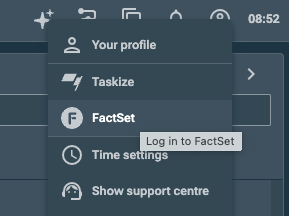

In [2]:
# Import common libraries
import os
import pandas as pd
import logging
import pytz
import random
from datetime import datetime, timezone
from IPython.core.display import HTML
logging.basicConfig(level = logging.INFO)

# Import LUSID libraries
import lusid as lu
import lusid.models as lm

import lusidjam
import lusid.extensions as le
from finbourne_sdk_utils.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from finbourne_sdk_utils import cocoon as cocoon

# Set pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.2f}".format

# Authenticate to SDK
# Run the Notebook in Jupyterhub for your LUSID domain and authenticate automatically
secrets_path = os.getenv("FBN_SECRETS_PATH")
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
config_loaders=[
    le.ArgsConfigurationLoader(access_token = lusidjam.RefreshingToken(), app_name = "LusidJupyterNotebook"),
    le.EnvironmentVariablesConfigurationLoader(),
    le.SecretsFileConfigurationLoader(secrets_path)]
api_factory = le.SyncApiClientFactory(config_loaders=config_loaders)

# Confirm success
api_client = api_factory.build(lu.ApplicationMetadataApi)
api_url = api_client.api_client.configuration._base_path.replace("api","")

print ('LUSID Environment :', api_url + "docs")
display(pd.DataFrame(api_client.get_lusid_versions().to_dict()))

LUSID Environment : https://lusid-pms-demo.lusid.com/docs


,apiVersion,buildVersion,excelVersion,links
0,v0,0.6.14980.0,0.5.3666,"{'relation': 'RequestLogs', 'href': 'https://l..."


In [3]:
configuration_recipe_api = api_factory.build(lu.api.ConfigurationRecipeApi)
portfolios_api = api_factory.build(lu.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lu.TransactionPortfoliosApi)
aggregation_api = api_factory.build(lu.AggregationApi)
quotes_api = api_factory.build(lu.QuotesApi)
instruments_api = api_factory.build(lu.InstrumentsApi)

In [4]:
scope = "realtime-valuation-factset"
portfolio_code = "portfolio"
recipe_code = "Factset"
default_currency = "GBP"

quotes_supplier = "Lusid"
quotes_field = "mid"
quotes_instrument_id = "ClientInternal"

## 1. Load Data

### 1.1 Instruments 

Create a mapping schema for the instruments using the provided FIGIs as the instrument identifiers. The instruments file is loaded into LUSID. 

In [14]:
# Read the Instruments static data file
# In real use case the user is expected to provide the Factset.instruments.csv file containing a set of Instruments
# When running in a pipeline the file won't exist to revert to the (empty) template
filename = "data/real-time-valuation/Factset.instruments.csv"

if os.path.isfile(filename):
  instruments_df = pd.read_csv(filename)
else:
  instruments_df = pd.read_csv( "data/real-time-valuation/Factset.instruments.template.csv")

instrument_mapping = {
    "identifier_mapping": {
        "Ticker" : "ticker",
        "FactSetId" : "factset_id",
        "ClientInternal": "ticker",
    },
    "required": {
        "name": "name",
        "currency": "currency"
    },
}

# Instruments can be loaded using a dataframe with file_type set to "instruments"
result = cocoon.load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    instrument_scope=scope,
    data_frame=instruments_df,
    mapping_required=instrument_mapping["required"],
    mapping_optional={},
    file_type="instruments",
    identifier_mapping=instrument_mapping["identifier_mapping"],
)

succ, failed, errors = cocoon.format_instruments_response(result)
display(pd.DataFrame(data=[{"success": len(succ), "failed": len(failed), "errors": len(errors)}]))

/Users/steve/work/code/notebooks/.venv/lib/python3.13/site-packages/finbourne_sdk_utils/cocoon/cocoon.py:1721: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_frame = data_frame.applymap(cocoon.utilities.convert_cell_value_to_string)


,success,failed,errors
0,52,0,0


### 1.2 Portfolio

Create a portfolio and populate with simulated holdings for the Instruments loaded above

In [6]:
portfolios = portfolios_api.list_portfolios_for_scope(
    scope=scope,
    filter=f"id.code eq '{portfolio_code}'"
)

if portfolios.values:
    print(f"Portfolio '{portfolio_code}' already exists in scope '{scope}' - deleting")
    portfolios_api.delete_portfolio(
        scope=scope,
        code=portfolio_code)
 
create_portfolio_request = lm.CreateTransactionPortfolioRequest(
    instrument_scopes=[scope],
    display_name="Realtime Test Portfolio",
    description="Realtime Test Portfolio",
    code=portfolio_code,
    created="2020-01-01T00:00:00+00:00",
    base_currency=default_currency,
)

response = transaction_portfolios_api.create_portfolio(
    scope=scope,
    create_transaction_portfolio_request=create_portfolio_request
)


Portfolio 'portfolio' already exists in scope 'realtime-valuation-factset' - deleting


### 1.3 Holdings

In [15]:
# Here we generate a Holdings dataset from the Instrument universe with fake holdings
# For simplicity, always use the same set of random numbers
rand = random.Random()
rand.seed("test")

holdings_df = instruments_df[['ticker', 'currency']].copy()
holdings_df['units'] = [rand.randrange(100,1000) for r in range(0,len(holdings_df))]
holdings_df['cost'] = [rand.randrange(1000,10000) for r in range(0,len(holdings_df))]
holdings_df['price'] = holdings_df['cost'] / holdings_df['units']

#holdings_df

In [16]:
holdings_mapping = {
    "identifier_mapping": {
        "Ticker": "ticker"
    },
    "required": {
        "effective_at": "$2020-01-01",
        "code": f"${portfolio_code}",
        "tax_lots.units": "units",
        "tax_lots.portfolio_cost": "cost",
        "tax_lots.cost.currency": "currency",
        "tax_lots.cost.amount": "cost"
    },
    "optional": {}
}

result = cocoon.load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=holdings_df,
    mapping_required=holdings_mapping["required"],
    mapping_optional=holdings_mapping["optional"],
    file_type="holdings",
    identifier_mapping=holdings_mapping["identifier_mapping"],
)

succ, failed = cocoon.format_holdings_response(result)

failed

/Users/steve/work/code/notebooks/.venv/lib/python3.13/site-packages/finbourne_sdk_utils/cocoon/cocoon.py:1721: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_frame = data_frame.applymap(cocoon.utilities.convert_cell_value_to_string)


,error_items,status


### 1.4 Prices

Load prices here to fall back on if the feed is not streaming - typically because the market is closed.

In [9]:
quotes_mapping = {
    "quote_id.quote_series_id.instrument_id_type": f"${quotes_instrument_id}",
    "quote_id.effective_at": "$2024-02-01",
    "quote_id.quote_series_id.provider": f"${quotes_supplier}",
    "quote_id.quote_series_id.quote_type": "$Price",
    "quote_id.quote_series_id.instrument_id": "ticker",
    "quote_id.quote_series_id.field" : f"${quotes_field}",
    "metric_value.unit": f"${default_currency}",
    "metric_value.value": "price"
}

result = cocoon.load_from_data_frame(
        api_factory=api_factory,
        scope=scope,
        data_frame=holdings_df,
        mapping_required=quotes_mapping,
        mapping_optional={},
        file_type="quotes",
)

succ, failed, errors = cocoon.format_quotes_response(result)
display(pd.DataFrame(data=[{"success": len(succ), "failed": len(failed), "errors": len(errors)}]))

/Users/steve/work/code/notebooks/.venv/lib/python3.13/site-packages/finbourne_sdk_utils/cocoon/cocoon.py:1721: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_frame = data_frame.applymap(cocoon.utilities.convert_cell_value_to_string)


,success,failed,errors
0,52,0,0


### 1.5 Exchange Rates

In [10]:
# Create dummy rates from GBP and CHF
rates = [
    ['GBP/USD', 1.26], 
    ['GBP/EUR', 1.17], 
    ['USD/CHF', 0.87],
]
 
instrument_id_type = "CurrencyPair"
value = "Rate"

rates_df = pd.DataFrame(rates, columns=[instrument_id_type, value])
 
rates_mapping = {
    "quote_id.quote_series_id.instrument_id_type": "$CurrencyPair",
    "quote_id.effective_at": "$2024-02-01",
    "quote_id.quote_series_id.provider": f"${quotes_supplier}",
    "quote_id.quote_series_id.quote_type": "$Rate",
    "quote_id.quote_series_id.instrument_id": instrument_id_type,
    "quote_id.quote_series_id.field" : f"${quotes_field}",
    "metric_value.unit": instrument_id_type,
    "metric_value.value": value
}


result = cocoon.load_from_data_frame(
        api_factory=api_factory,
        scope=scope,
        data_frame=rates_df,
        mapping_required=rates_mapping,
        mapping_optional={},
        file_type="quotes",
)

succ, failed, errors = cocoon.format_quotes_response(result)
display(pd.DataFrame(data=[{"success": len(succ), "failed": len(failed), "errors": len(errors)}]))

/Users/steve/work/code/notebooks/.venv/lib/python3.13/site-packages/finbourne_sdk_utils/cocoon/cocoon.py:1721: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_frame = data_frame.applymap(cocoon.utilities.convert_cell_value_to_string)


,success,failed,errors
0,3,0,0


## 2. Run valuation

In [11]:
configuration_recipe = lm.ConfigurationRecipe(
        scope=scope,
        code=recipe_code,
        market=lm.MarketContext(
            market_rules=[
                # First source is real-time
                lm.MarketDataKeyRule(
                    key="Quote.FactSetId.*",
                    supplier="FactSet",
                    dataScope="LUSID-FactSet",
                    quoteType="Price",
                    field="bid",
                    quoteInterval="5D.Live",
                    priceSource="delayed",
                    sourceSystem="FactSet/Streaming",
                    fallThroughOnAccessDenied=False
                ),
                # Fall back to stored quotes
                lm.MarketDataKeyRule(
                    key="Quote.ClientInternal.*",
                    supplier=quotes_supplier,
                    quote_type="Price",
                    data_scope=scope,
                    field=quotes_field,
                    quote_interval="10Y.0D"
                ),
                # Fall back to stored FX rates
                lm.MarketDataKeyRule(
                    key='Fx.CurrencyPair.*',
                    data_scope=scope,
                    supplier='Lusid',
                    quote_type='Rate',
                    quote_interval='10Y.0D',
                    field="mid"
                )
            ],
            options=lm.MarketOptions(
                default_supplier="Lusid",
                default_instrument_code_type="LusidInstrumentId",
                default_scope=scope,
                attempt_to_infer_missing_fx=True
            ),
        ),
        pricing=lm.PricingContext(
            options={"AllowPartiallySuccessfulEvaluation": True},
        ),
    )

upsert_configuration_recipe_response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(
        configuration_recipe=configuration_recipe
    )
)

In [12]:
# Pull the data aggregation by passing the effectiveAt date
# NOTE: This won't return Factset prices as this requires the user to be logged into Factset via the UI
def aggregation_request(effectiveAt):
    return lm.ValuationRequest( 
        recipe_id = lm.ResourceId(
            scope = scope,
            code = recipe_code
        ),
        metrics = [
            lm.AggregateSpec(key="Instrument/default/Name", op="Value"),
            lm.AggregateSpec(key="Valuation/PV", op="Proportion"),
            lm.AggregateSpec(key="Valuation/PV", op="Sum"),
            lm.AggregateSpec(key="Holding/default/Units", op="Sum"),
            lm.AggregateSpec(key="Quotes/Price", op="Value"),
            lm.AggregateSpec(key="Quotes/Price/EffectiveAt", op="Value"),
            lm.AggregateSpec(key="Quotes/Price/Provider", op="Value"),
            lm.AggregateSpec(key="Quotes/Price/PriceSource", op="Value"),
        ],
        group_by=["Instrument/default/Name"],
        # choose the valuation date for the request - set using effectiveAt
        valuation_schedule=lm.ValuationSchedule(effective_at=effectiveAt),
        portfolio_entity_ids = [lm.PortfolioEntityId(
                                                        scope = scope,
                                                        code = portfolio_code,
                                                        portfolio_entity_type="SinglePortfolio" 
            )]
        )

aggregation = aggregation_api.get_valuation(
  valuation_request=aggregation_request(effectiveAt=datetime.now(pytz.UTC).isoformat())
)
pd.DataFrame(aggregation.data)

UnauthorizedException: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 17 Sep 2025 08:27:55 GMT', 'Content-Type': 'application/problem+json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'x-rate-limit-limit': '1m', 'x-rate-limit-remaining': '4985', 'x-rate-limit-reset': '2025-09-17T08:28:43.7269030Z', 'lusid-meta-success': 'False', 'lusid-meta-requestid': '2025091708-dcaa1d27f216422fb95ddade9e08f2b6', 'lusid-meta-correlationid': '2025091708-dcaa1d27f216422fb95ddade9e08f2b6', 'lusid-meta-duration': '1108', 'x-envoy-upstream-service-time': '1113', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'Server': 'FINBOURNE', 'Content-Security-Policy': "default-src 'self' https://*.lusid.com https://*.finbourne.com; script-src 'unsafe-inline' 'self' https://*.lusid.com https://*.finbourne.com https://editor.swagger.io; font-src 'self' fonts.googleapis.com; img-src data: 'self' https://*.lusid.com https://*.finbourne.com https://validator.swagger.io; style-src 'unsafe-inline' 'self' https://*.lusid.com https://*.finbourne.com; report-uri https://lusid.report-uri.com/r/d/csp/enforce", 'X-Frame-Options': 'SAMEORIGIN', 'Permissions-Policy': 'accelerometer=(), ambient-light-sensor=(), autoplay=(self), battery=(), camera=(), cross-origin-isolated=(self), display-capture=(), document-domain=*, encrypted-media=(), execution-while-not-rendered=(), execution-while-out-of-viewport=(), fullscreen=(self), geolocation=(self), gyroscope=(), keyboard-map=(), magnetometer=(), microphone=(), midi=(), navigation-override=(), payment=(), picture-in-picture=(), publickey-credentials-get=(), screen-wake-lock=(), sync-xhr=(), usb=(), web-share=(), xr-spatial-tracking=()', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'X-XSS-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Expect-CT': "max-age=3600, enforce, report-uri='https://lusid.report-uri.com/r/d/ct/enforce'", 'Access-Control-Max-Age': '600'})
HTTP response body: {"name":"InvalidRequestHeaders","errorDetails":[],"code":188,"type":"https://docs.lusid.com/#section/Error-Codes/188","title":"One or more failures occurred.","status":401,"detail":"One or more failures occurred. Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Username header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Serial header., Requests to FactSet/Streaming service must contain a X-LUSID-Vendor-Factset-Token header.","instance":"https://lusid-pms-demo.lusid.com/app/insights/logs/2025091708-dcaa1d27f216422fb95ddade9e08f2b6","extensions":{}}


In [ ]:
display(HTML("<h1>Links</h1>"))

display(HTML(f'''
  <a href="{api_url}app/dashboard/holdings?scope={scope}&code={portfolio_code}&entityType=Portfolio&recipeScope={scope}&recipeCode={recipe_code}"
  target="_blank">
    Holdings
  </a>'''))

display(HTML(f'''
  <a href="{api_url}app/dashboard/valuations?scope={scope}&code={portfolio_code}&entityType=Portfolio&recipeScope={scope}&recipeCode={recipe_code}"
  target="_blank">
    Valuation with real-time prices
  </a>'''))